In [1]:
import asset_asrl as ast
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.time import TimeDelta
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import get_body_barycentric_posvel
from astropy.coordinates import get_body_barycentric

# Custom Libs
from body import *
from orbit import *
from orbit_util import *
from universal_variable import *

# ASSET thigns
vf        = ast.VectorFunctions
oc        = ast.OptimalControl
Args      = vf.Arguments

### Setting up constants

In [2]:
G = const.G.to(u.km**3 / (u.kg * u.s**2))  # convert to km
EARTH_MASS = const.M_earth
EARTH_MU = const.GM_earth.to(u.km**3 / u.s**2)
MOON_RAD = 3390 * u.km
MOON_MASS = (7.34 * 10**22) * u.kg
MOON_MU = MOON_MASS * G
SAT_MASS = 10 #kg

epoch = Time("2026-11-08")
solar_system_ephemeris.set('de432s')
earth = Body(EARTH_MASS, epoch, celestial_body="earth", color="green")
moon = Body(MOON_MASS, epoch, celestial_body="moon", color='grey')
sat = Spacecraft(SAT_MASS, epoch, label="sat", color="purple")

# Define Earth Parking Orbit
depatrure_f0 = -179
earth_parking = Orbit(mu=EARTH_MU,
                      a=32000*u.km,
                      e=0.80*u.km/u.km,  # unitless
                      f0=(depatrure_f0*u.deg).to(u.rad),
                      inc=(28*u.deg).to(u.rad),
                      raan=(175*u.deg).to(u.rad),
                      aop=(240*u.deg).to(u.rad)
                      )

earth_parking.p = earth_parking.calc_p(earth_parking.a, earth_parking.e)
earth_parking.energy = earth_parking.calc_energy(
    earth_parking.a, earth_parking.mu)

#### Defining ASSET ODE and Integrator 

In [3]:
class TwoBody(oc.ODEBase):
    def __init__(self,earth_mu, moon_mu):
        
        XVars = 12
        UVars = 0
        PVars = 0 

        XtU = oc.ODEArguments(XVars,UVars,PVars)

        sat_r, sat_v, moon_r, moon_v = XtU.XVec().tolist([(0,3),(3,3),(6,3),(9,3)])

        moon_wrt_sat = moon_r - sat_r # From S/C to moon 

        #Accel on sat from earth and moon
        sat_a = -earth_mu*sat_r.normalized_power3() + moon_mu*moon_wrt_sat.normalized_power3()

        #Accel on moon from earth
        moon_a = -earth_mu*moon_r.normalized_power3()

        sat_r_dot = sat_v
        sat_v_dot = sat_a
        moon_r_dot = moon_v
        moon_v_dot = moon_a

        ode = vf.stack([sat_r_dot,sat_v_dot,moon_r_dot,moon_v_dot])
        super().__init__(ode,XVars)

TBode = TwoBody(EARTH_MU.value, MOON_MU.value)


#### Propagating Earth Orbit aka. initial guess for phase 1

In [4]:
earth_parking.inc.value

np.float64(0.4886921905584123)

In [ ]:
sat_orbit = earth_parking

# Calcualte Intial Position of satillite in earth orbit
r = sat_orbit.r_at_true_anomaly(sat_orbit.e, sat_orbit.p, sat_orbit.f0)

r_pqw, v_pqw = orb_2_pqw(r.value,
                         sat_orbit.f0.value, sat_orbit.e.value,
                         sat_orbit.p.value, sat_orbit.mu.value)

r_eci, v_eci = perif_2_eci(r_pqw, v_pqw, sat_orbit.inc.value,
                           sat_orbit.raan.value, sat_orbit.aop.value)

sat.r0 = r_eci * u.km
sat.v0 = v_eci * (u.km/u.s)

#Calculate intial position of moon at epoch
moon_r0, moon_v0 = get_body_barycentric_posvel(moon.label, epoch)
moon_r0 = moon_r0.xyz.to(u.km).value
moon_v0 = moon_v0.xyz.to(u.km/u.s).value

earth_r0, earth_v0 = get_body_barycentric_posvel(earth.label, epoch)
earth_r0 = earth_r0.xyz.to(u.km).value
earth_v0 = earth_v0.xyz.to(u.km/u.s).value

#Time
t0 = 0
tf = sat_orbit.period(sat_orbit.a, sat_orbit.mu).value
dt = 30
n = int(np.round((tf-t0)/dt))
#print(f'n = {n}')

X0t0 = np.zeros((13))
X0t0[0:3] = sat.r0.value
X0t0[3:6] = sat.v0.value
X0t0[6:9] = (earth_r0 - moon_r0)
X0t0[9:12]= (earth_v0 - moon_v0)
X0t0[12] = t0

# Define Event to find apoapis
def ApseFunc():
    R,V = Args(13).tolist([(0,3),(3,3)])
    return R.dot(V)

direction = -1
stopcode = True
ApoApseEvent  = (ApseFunc(),direction,stopcode)

Events = [ApoApseEvent]

# Inegrate Earth Orbit
DefStepSize = dt
MinStepSize = dt
MaxStepSize = dt
TBInteg = TBode.integrator("DOPRI87", DefStepSize)
#TBInteg.setStepSizes(DefStepSize,MinStepSize,MaxStepSize)
EarthOrbTraj, EventLocs = TBInteg.integrate_dense(X0t0,tf,n,Events)

# Saving all the data for PHASE_1
data_dict = {
    "epoch": epoch,
    "sat_orbit": sat_orbit,
    "dt": dt,
    "n_steps": n,
    "t0": t0,
    "tf": tf,
    "y0": X0t0,
    "EarthOrbTraj": EarthOrbTraj,
    "EventLocs": EventLocs
}
leg_1_data = np.save("phase1_data", np.array(data_dict))
np.savez("phase1_bodies_data", np.array(sat), np.array(earth), np.array(moon))

h_ar_phase1 = np.zeros(len(EarthOrbTraj))
h_ar_t = np.zeros(len(EarthOrbTraj))
r0 = EarthOrbTraj[0][0:3]
v0 = EarthOrbTraj[0][3:6]
h0 = np.linalg.norm(np.cross(r0,v0))
for i in range(len(EarthOrbTraj)):
    r = EarthOrbTraj[i][0:3]
    v = EarthOrbTraj[i][3:6]
    h_ar_phase1[i] = np.linalg.norm(np.cross(r,v)) - h0
    h_ar_t[i] = EarthOrbTraj[i][-1]

ax1 = plt.subplot(1, 1, 1)
ax1.plot(h_ar_t, h_ar_phase1, color='orange', label='phase_1')
ax1.set_xlabel("time (seconds)")
ax1.set_ylabel("h")
ax1.set_title("Angular Momentum Earth_Orbit")
ax1.legend(loc='lower left')
ax1.grid(True)
plt.show()

#### Propagating Earth-moon transfer aka. initial guess for phase 2

In [ ]:
# Lamberts to guess transfer vel
r1_lambert = EarthOrbTraj[-1][0:3]
earth_orbit_tof = TimeDelta(int(EarthOrbTraj[-1][-1]),format='sec')
tof_guess = earth_orbit_tof + TimeDelta(int(86400*3),format='sec')
r2_lambert = get_body_barycentric(moon.label,epoch+tof_guess).xyz.to(u.km).value
a, p, e, tranfer_v1, tranfer_v2 = universal_lambert(r1_lambert, 
                                                    r2_lambert, 
                                                    tof_guess.value, 
                                                    earth_parking.mu.value,
                                                    desired_path='short')

sat_r0 = EarthOrbTraj[-1][0:3]
sat_v0 = tranfer_v1

#Calculate intial position of moon at epoch
moon_r0 = EarthOrbTraj[-1][6:9]
moon_v0 = EarthOrbTraj[-1][9:12]

#Time
t0 = EarthOrbTraj[-1][12]
tf = t0 + 86400*15
dt = 3600/2
n = int(np.round((tf-t0)/dt))
#print(f'n = {n}')

X0t0 = np.zeros((13))
X0t0[0:3] = sat_r0
X0t0[3:6] = sat_v0
X0t0[6:9] = moon_r0
X0t0[9:12]= moon_v0
X0t0[12] = t0

DefStepSize = dt
MinStepSize = dt/2
MaxStepSize = dt*2
TBInteg = TBode.integrator(DefStepSize)
TBInteg.setStepSizes(DefStepSize,MinStepSize,MaxStepSize)
MoonTransferTraj = TBInteg.integrate_dense(X0t0,tf,n)

# Saving all the data for PHASE_2
data_dict = {
    "dt": dt,
    "n_steps": n,
    "t0": t0,
    "tf": tf,
    "y0": X0t0,
    "MoonTransferTraj": MoonTransferTraj
}
leg_1_data = np.save("phase2_data", np.array(data_dict))
np.savez("phase2_bodies_data", np.array(sat), np.array(earth), np.array(moon))

In [ ]:
print(f'Guess transfer vel to moon: {tranfer_v1}')
print(f'transfer a: {a}')
print(f'transfer e: {e}')

print(f"\n 1 last pos: {EarthOrbTraj[-1][0:3]}")
print(f"phase 2 intial pos : {MoonTransferTraj[0][0:3]}")

dv = MoonTransferTraj[0][3:6] - EarthOrbTraj[-1][3:6]
print(f"\nphase 1 last vel: {EarthOrbTraj[-1][3:6]}")
print(f"phase 2 first vel: {MoonTransferTraj[0][3:6]}")
print(f"DeltaV: {dv}")
print(f"DeltaV Mag: {np.linalg.norm(dv)}")

Guess transfer vel to moon: [ 0.55688922 -0.08630873  3.67795779]
transfer a: -122677033.70744607
transfer e: 1.0004171163424331

 1 last pos: [-32528.37886243 -41360.70409211  23415.42314784]
phase 2 intial pos : [-32528.37886243 -41360.70409211  23415.42314784]

phase 1 last vel: [ 0.97099915 -0.60524608  0.27613423]
phase 2 first vel: [ 0.55688922 -0.08630873  3.67795779]
DeltaV: [-0.41410992  0.51893735  3.40182357]
DeltaV Mag: 3.466004410335441


In [ ]:
print(f"phase 1 t0: {EarthOrbTraj[0][12]}")
print(f"phase 1 tf: {EarthOrbTraj[-1][12]}")
print(f"phase 2 t0: {MoonTransferTraj[0][12]}")
print(f"phase 2 tf: {MoonTransferTraj[-1][12]}")

phase 1 t0: 0.0
phase 1 tf: 56126.46191603682
phase 2 t0: 56126.46191603682
phase 2 tf: 1352126.461916037


# Two Phase Transfer

In [ ]:
def TargetOrbit(a_t,e_t,inc_t,raan_t,aop_t,mu):
    R,V = Args(6).tolist([(0,3),(3,3)])
    r    = R.norm()
    v    = V.norm()

    # Cordinate vectors used for calcs
    cv = Args(3)
    I = np.array([1, 0, 0])
    J = np.array([0, 1, 0])
    K = np.array([0, 0, 1])

    # Angular momentum
    H = R.cross(V)
    h = H.norm()

    # Node vector
    N = vf.cross(K,H)/vf.cross(K,H).norm()

    # Semimajor Axis
    energy = ((v**2) / 2) - (mu/r)
    a = -mu/(2*energy)

    # Eccentricity 
    e_vec = (V.cross(H)/mu) - (R.normalized())
    e = e_vec.norm()

    #INC
    cos_i = vf.dot(K,H) / h
    inc = vf.arccos(cos_i)

    #RAAN
    raan = vf.arctan(vf.dot(J,N) / vf.dot(I,N))

    rann_quad_check = vf.dot(N,I)
    if rann_quad_check < 0:
        raan += np.pi

    # AOP
    aop = vf.arccos(e_vec.dot(N) / e)

    aop_quad_check = e_vec.dot(K)
    if aop_quad_check < 0:
        aop = (2*np.pi) - aop

    f = vf.arccos(e_vec.dot(R))/(e*r)

    return vf.stack([a,e,inc,raan,aop]) - np.array([a_t,e_t,inc_t,raan_t,aop_t])


def AngularMomentumConstraint():
    R0,V0,RF,VF = Args(12).tolist([(0,3),(3,3),(6,3),(9,3)])

    H0 = vf.cross(R0, V0)  # Angular momentum at start
    HF = vf.cross(RF, VF)  # Angular momentum at end

    return (HF - H0) 

##### Define Phases and Constraints

In [ ]:
# Define Phases
IG1 = EarthOrbTraj
IG2 = MoonTransferTraj

phase1 = TBode.phase('LGL3', IG1, 50)
phase1.setControlMode("HighestOrderSpline")
phase2 = TBode.phase('LGL3', IG2, 50)
phase2.setControlMode("HighestOrderSpline")

# Target orbit for phase1
a_t = earth_parking.a.value
e_t = earth_parking.e.value
inc_t = earth_parking.inc.value
raan_t = earth_parking.raan.value
aop_t = earth_parking.aop.value
mu = earth_parking.mu.value

phase1.addEqualCon("Last",TargetOrbit(a_t,e_t,inc_t,raan_t,aop_t,mu),range(0,6))
#phase1.addEqualCon("FirstandLast", AngularMomentumConstraint(), range(0,6))

# Constrain phases constant angular momentum
#phase2.addEqualCon("FirstandLast", AngularMomentumConstraint(), range(0,6))

# Time Bounds
#phase1.addLowerDeltaTimeBound(0)
#phase1.addUpperDeltaTimeBound(earth_orbit_tof.value)
phase2.addLowerDeltaTimeBound(86400 * 2) 
phase2.addUpperDeltaTimeBound(86400 * 6) 

# Add Inequality Constraint to make sat end near moon. 
def NearMoonInequalCon():
    rm, rs = Args(6).tolist([(0,3),(3,3)])
    target_altitude = 200
    return (rs - rm).norm() - (MOON_RAD.value + 200)

XtUVars = [0,1,2,6,7,8] #sat and moon pos in state vars
OPVars  = []
SPVars  = []

phase2.addInequalCon('Last',NearMoonInequalCon(),XtUVars,OPVars,SPVars)



1

#### Define and solve OCP

DeltaV: 8526687.830319984
TimeDiff: -2.9103830456733704e-10


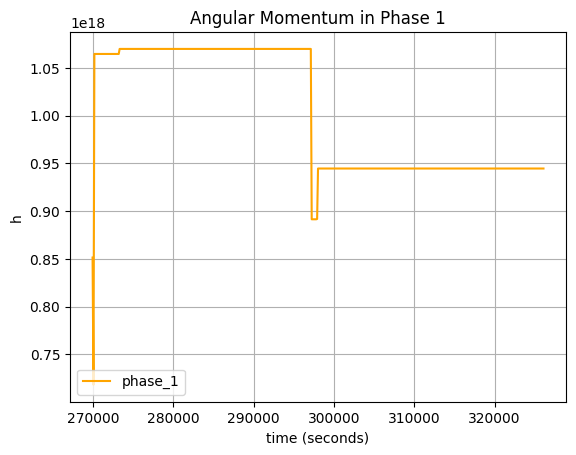

In [ ]:
# Define Optimal Control Problem
ocp  = oc.OptimalControlProblem()
ocp.addPhase(phase1)
ocp.addPhase(phase2)

#Make pos in phases continuous
ocp.addForwardLinkEqualCon(phase1,phase2,[0,1,2,6,7,8,9,10,11,12])

# Linking Objetive of minimizing deltaV
def DeltaVObjective():
    v1,v2 = Args(6).tolist([(0,3),(3,3)])
    dv = (v2-v1).norm()
    return dv

XtUvars0 = range(3,6)
XtUvars1 = range(3,6)
ocp.addLinkObjective(DeltaVObjective(), 
                    phase1,'Last', XtUvars0,[],[],
                    phase2,'First',XtUvars1,[],[])

ocp.optimizer.set_OptLSMode("L1")
ocp.optimizer.set_MaxLSIters(100)

#Solve
ocp.solve_optimize()

Phase1Traj = phase1.returnTraj()
Phase2Traj = phase2.returnTraj()

data_dict = {
    "Phase1Traj": Phase1Traj,
    "Phase2Traj": Phase2Traj,
}
leg_1_data = np.save("ocp_data", np.array(data_dict))

dv = np.linalg.norm(Phase1Traj[-1][3:6] - Phase2Traj[0][3:6])

# Time differnce between start and end of phase
time_diff = Phase2Traj[0][12] - Phase1Traj[-1][12]
a

print(f'DeltaV: {dv}')
print(f'TimeDiff: {time_diff}')


h_ar_phase1 = np.zeros(len(Phase1Traj))
h_ar_t = np.zeros(len(Phase1Traj))
for i in range(len(Phase1Traj)):
    r = Phase1Traj[i][0:3]
    v = Phase1Traj[i][3:6]
    h_ar_phase1[i] = np.linalg.norm(np.cross(r,v))
    h_ar_t[i] = Phase1Traj[i][-1]

ax1 = plt.subplot(1, 1, 1)
ax1.plot(h_ar_t, h_ar_phase1, color='orange', label='phase_1')
ax1.set_xlabel("time (seconds)")
ax1.set_ylabel("h")
ax1.set_title("Angular Momentum in Phase 1")
ax1.legend(loc='lower left')
ax1.grid(True)
plt.show()

In [ ]:
Phase1Traj[0]

array([ 1.47916805e+11,  1.31835679e+11,  1.85350927e+11, -3.45612191e+06,
        7.35396325e+05, -1.52890907e+05,  4.97666679e+11, -5.44697317e+11,
       -3.27975870e+11, -6.80191826e+06,  6.72607579e+06,  4.49018912e+06,
        2.69968768e+05])

In [ ]:
first_run = np.linalg.norm(Phase1Traj[-1][3:6] - Phase2Traj[0][3:6])
first_run

np.float64(8526687.830319984)

In [ ]:
print(f"phase 1 t0: {EarthOrbTraj[0][12]}")
print(f"phase 1 tf: {EarthOrbTraj[-1][12]}")
print(f"phase 2 t0: {MoonTransferTraj[0][12]}")
print(f"phase 2 tf: {MoonTransferTraj[-1][12]}")

phase 1 t0: 0.0
phase 1 tf: 56126.46191603682
phase 2 t0: 56126.46191603682
phase 2 tf: 1352126.461916037


In [ ]:
Phase1Traj[0][12]/86400

np.float64(3.124638516648661)

In [ ]:
Phase1Traj[:][12] < 0

array([False, False, False,  True,  True,  True, False,  True,  True,
        True, False, False, False])